# Week 3 — Logistic Regression

_File: 03-logistic-regression.ipynb_

Goal: implement logistic regression for classification with NumPy.
Steps: implement sigmoid function, logistic loss, gradient descent, regularization.

Following Andrew Ng ML Course - Week 3

## Day 1 — Sigmoid Function and Classification


## 1. The Sigmoid Function

### Understanding the Problem

Linear regression works great for predicting continuous values, but what about classification? We need to predict categories (like "spam" vs "not spam" or "fraud" vs "legitimate").

**Key insight:** Instead of predicting a continuous value, we want to predict a probability between 0 and 1.

### The Sigmoid Function

The sigmoid function maps any real number to the range (0,1):

92826
g(z) = rac{1}{1 + e^{-z}}
92826

**Properties:**
- When z → +∞, g(z) → 1
- When z → -∞, g(z) → 0  
- When z = 0, g(z) = 0.5
- Always smooth and differentiable


Sigmoid values:
g(-5) = 0.0067
g(-2) = 0.1192
g( 0) = 0.5000
g( 2) = 0.8808
g( 5) = 0.9933


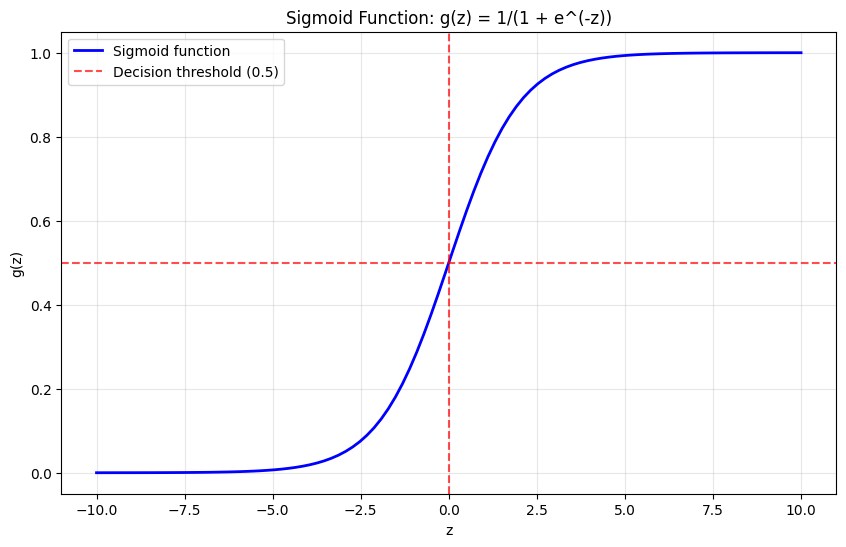

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    """
    Sigmoid function implementation with numerical stability.
    
    Args:
        z: Input value(s) (can be scalar, vector, or array)
    
    Returns:
        Sigmoid output in range (0,1)
    """
    z = np.asarray(z)
    # Clip extreme values to prevent overflow
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

# Test the sigmoid function
test_values = np.array([-5, -2, 0, 2, 5])
print("Sigmoid values:")
for z, g_z in zip(test_values, sigmoid(test_values)):
    print(f"g({z:2d}) = {g_z:.4f}")

# Visualize the sigmoid function
z_range = np.linspace(-10, 10, 100)
plt.figure(figsize=(10, 6))
plt.plot(z_range, sigmoid(z_range), 'b-', linewidth=2, label='Sigmoid function')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Decision threshold (0.5)')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
plt.xlabel('z')
plt.ylabel('g(z)')
plt.title('Sigmoid Function: g(z) = 1/(1 + e^(-z))')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 2. The Logistic Regression Model

### From Linear to Logistic

**Linear Regression Model:**
\[
f(x) = w \cdot x + b
\]

**Logistic Regression Model:**
\[
f(x) = g(w \cdot x + b) = \frac{1}{1 + e^{-(w \cdot x + b)}}
\]

**Key difference:** We wrap the linear combination in a sigmoid function to get probabilities.

### Interpreting the Output

- **f(x)** represents P(y=1|x) - the probability that y=1 given input x
- **f(x) = 0.8** means "80% chance this example belongs to class 1"
- **f(x) = 0.2** means "20% chance this example belongs to class 1"

### Decision Boundary

The decision boundary is where we switch from predicting class 0 to class 1:

\[
w \cdot x + b = 0
\]

**Decision rule:**
- If f(x) ≥ 0.5 → predict class 1
- If f(x) < 0.5 → predict class 0

**Key insight:** The decision boundary is linear, but with polynomial features, it can become non-linear!

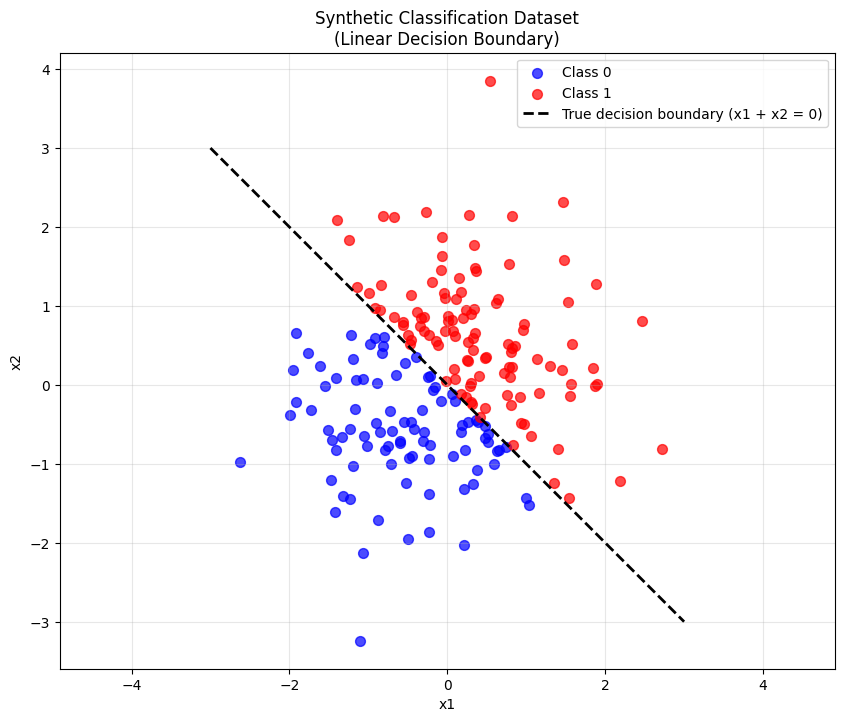

Dataset shape: (200, 2)
Class distribution: [ 90 110]
Class 0: 90 samples, Class 1: 110 samples


In [2]:
# Create a synthetic dataset for classification
np.random.seed(42)  # For reproducible results
m = 200

# Generate features
x1 = np.random.normal(0.0, 1.0, size=m)
x2 = np.random.normal(0.0, 1.0, size=m)

# Create a linear decision boundary: x1 + x2 = 0
# Points above the line (x1 + x2 > 0) are class 1, below are class 0
y = (x1 + x2 > 0).astype(int)

# Combine features into design matrix
X = np.column_stack([x1, x2])

# Visualize the dataset
plt.figure(figsize=(10, 8))
plt.scatter(X[y==0, 0], X[y==0, 1], s=50, label='Class 0', alpha=0.7, color='blue')
plt.scatter(X[y==1, 0], X[y==1, 1], s=50, label='Class 1', alpha=0.7, color='red')

# Draw the true decision boundary (line: x1 + x2 = 0)
x_line = np.linspace(-3, 3, 100)
y_line = -x_line  # x1 + x2 = 0, so x2 = -x1
plt.plot(x_line, y_line, 'k--', linewidth=2, label='True decision boundary (x1 + x2 = 0)')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic Classification Dataset\n(Linear Decision Boundary)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Class 0: {np.sum(y==0)} samples, Class 1: {np.sum(y==1)} samples")

## 3. The Logistic Loss Function

### Why Not Squared Error?

In linear regression, we used squared error: (f(x) - y)². But for classification, this doesn't make sense!

**Problems with squared error for classification:**
- When y=1 and f(x)=0.8, error = (0.8-1)² = 0.04 (small penalty)
- When y=1 and f(x)=0.1, error = (0.1-1)² = 0.81 (large penalty)
- But 0.1 is a very confident wrong prediction - it should be penalized heavily!

### The Logistic Loss Function

**Single-example loss:**
\[
L(f, y) = -y \log(f) - (1-y) \log(1-f)
\]

**Why this works:**
- When y=1: L = -log(f) → penalizes small f heavily
- When y=0: L = -log(1-f) → penalizes large f heavily
- When f is close to y: loss is small
- When f is far from y: loss is large

**Cost function (average loss):**
\[
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} L(f^{(i)}, y^{(i)})
\]

**Key advantage:** This cost function is convex, making gradient descent reliable!

Cost without regularization: 0.6206
Cost with regularization (λ=0.1): 0.6206


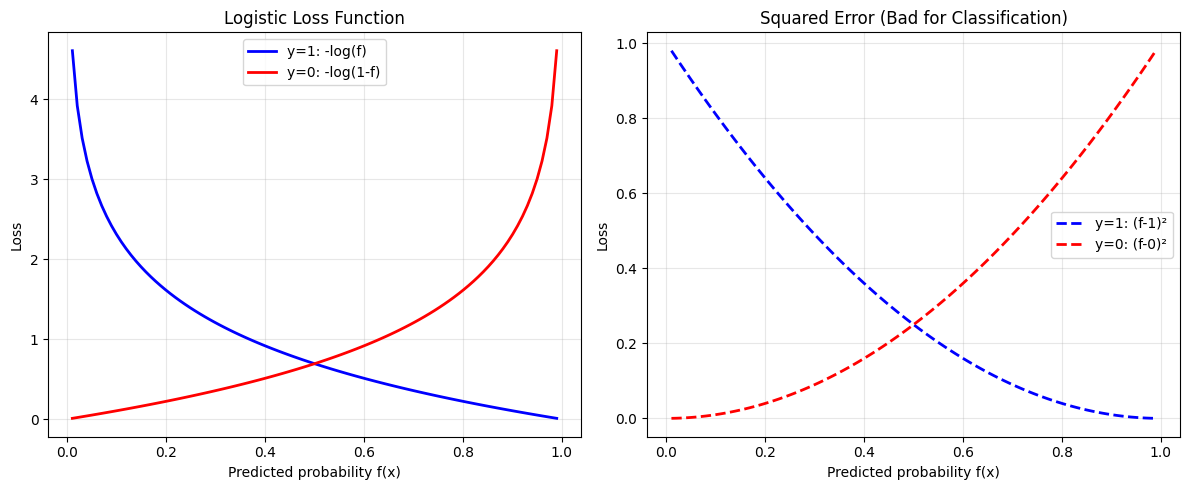

In [3]:
def compute_cost(X, y, w, b, reg_lambda=0.0):
    """
    Compute the logistic regression cost function.
    
    Args:
        X: Input features (m, n)
        y: True labels (m,)
        w: Weight vector (n,)
        b: Bias term (scalar)
        reg_lambda: Regularization parameter (default: 0.0)
    
    Returns:
        Cost value (scalar)
    """
    m = X.shape[0]
    
    # Compute predictions
    z = X @ w + b
    f = sigmoid(z)
    
    # Add small epsilon to prevent log(0)
    eps = 1e-12
    f = np.clip(f, eps, 1-eps)
    
    # Compute logistic loss
    cost = -np.mean(y * np.log(f) + (1-y) * np.log(1-f))
    
    # Add L2 regularization if specified
    if reg_lambda > 0:
        cost += (reg_lambda / (2*m)) * np.sum(w * w)
    
    return float(cost)

# Test the cost function
w_test = np.array([0.1, 0.2])
b_test = 0.5
cost_no_reg = compute_cost(X, y, w_test, b_test, reg_lambda=0.0)
cost_with_reg = compute_cost(X, y, w_test, b_test, reg_lambda=0.1)

print(f"Cost without regularization: {cost_no_reg:.4f}")
print(f"Cost with regularization (λ=0.1): {cost_with_reg:.4f}")

# Visualize how cost changes with different predictions
f_range = np.linspace(0.01, 0.99, 100)
loss_y1 = -np.log(f_range)  # When y=1
loss_y0 = -np.log(1-f_range)  # When y=0

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(f_range, loss_y1, 'b-', linewidth=2, label='y=1: -log(f)')
plt.plot(f_range, loss_y0, 'r-', linewidth=2, label='y=0: -log(1-f)')
plt.xlabel('Predicted probability f(x)')
plt.ylabel('Loss')
plt.title('Logistic Loss Function')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show why squared error is bad for classification
squared_error_y1 = (f_range - 1)**2
squared_error_y0 = (f_range - 0)**2
plt.plot(f_range, squared_error_y1, 'b--', linewidth=2, label='y=1: (f-1)²')
plt.plot(f_range, squared_error_y0, 'r--', linewidth=2, label='y=0: (f-0)²')
plt.xlabel('Predicted probability f(x)')
plt.ylabel('Loss')
plt.title('Squared Error (Bad for Classification)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Day 4 — Gradients and Gradient Descent (vectorized)
- dJ/dw = (1/m) Xᵀ(f - y);  dJ/db = (1/m) Σ(f - y)
- With L2 regularization (λ), add (λ/m)*w to dJ/dw; don’t regularize b.

In [4]:
def compute_gradient(X, y, w, b, reg_lambda=0.0):
    """
    Compute gradients for logistic regression.
    
    Args:
        X: Input features (m, n)
        y: True labels (m,)
        w: Weight vector (n,)
        b: Bias term (scalar)
        reg_lambda: Regularization parameter (default: 0.0)
    
    Returns:
        dj_dw: Gradient with respect to w (n,)
        dj_db: Gradient with respect to b (scalar)
    """
    m = X.shape[0]
    
    # Compute predictions
    f = sigmoid(X @ w + b)
    
    # Compute error
    err = f - y
    
    # Compute gradients
    dj_dw = (X.T @ err) / m
    dj_db = np.sum(err) / m
    
    # Add regularization to weight gradient
    if reg_lambda > 0:
        dj_dw = dj_dw + (reg_lambda / m) * w
    
    return dj_dw, float(dj_db)

def gradient_descent(X, y, alpha=0.1, iters=500, reg_lambda=0.0, verbose=False):
    """
    Perform gradient descent to minimize logistic regression cost.
    
    Args:
        X: Input features (m, n)
        y: True labels (m,)
        alpha: Learning rate
        iters: Number of iterations
        reg_lambda: Regularization parameter
        verbose: Whether to print progress
    
    Returns:
        Dictionary with optimized parameters and cost history
    """
    m, n = X.shape
    
    # Initialize parameters
    w = np.zeros(n)
    b = 0.0
    J_hist = []
    
    # Gradient descent loop
    for i in range(iters):
        # Compute gradients
        dj_dw, dj_db = compute_gradient(X, y, w, b, reg_lambda)
        
        # Update parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        # Record cost
        cost = compute_cost(X, y, w, b, reg_lambda)
        J_hist.append(cost)
        
        # Print progress every 100 iterations
        if verbose and i % 100 == 0:
            print(f"Iteration {i:4d}: Cost = {cost:.6f}")
    
    return {'w': w, 'b': b, 'J_hist': J_hist}

# Test gradient computation
w_test = np.array([0.1, 0.2])
b_test = 0.5
dj_dw, dj_db = compute_gradient(X, y, w_test, b_test, reg_lambda=0.1)
print(f"Gradient w: {dj_dw}")
print(f"Gradient b: {dj_db:.6f}")

Gradient w: [-0.22515061 -0.25063263]
Gradient b: 0.074077


## 5. Training the Model

### Training Without Regularization

Let's train our first logistic regression model and observe the learning curve.

Training logistic regression model...
Iteration    0: Cost = 0.677633
Iteration  100: Cost = 0.290065
Iteration  200: Cost = 0.227645
Iteration  300: Cost = 0.198640
Iteration  400: Cost = 0.180897
Iteration  500: Cost = 0.168521
Iteration  600: Cost = 0.159196
Iteration  700: Cost = 0.151804
Iteration  800: Cost = 0.145732
Iteration  900: Cost = 0.140609


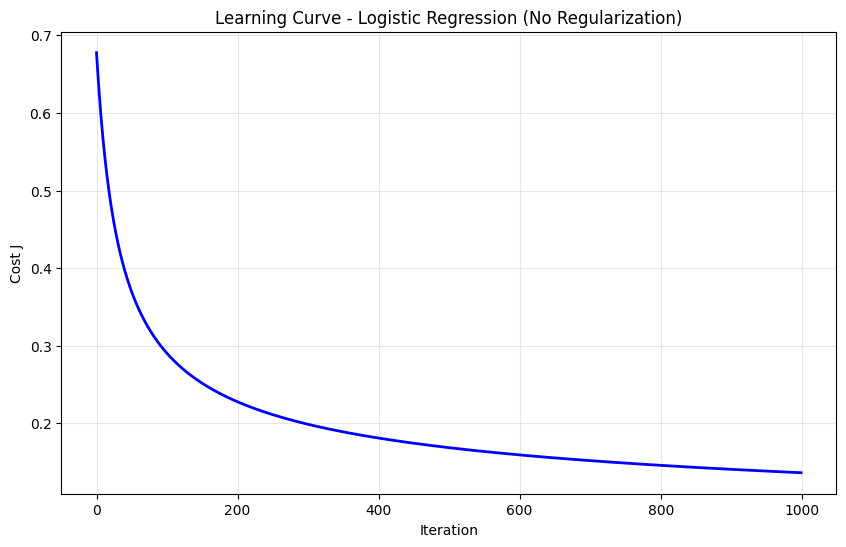


Final cost: 0.136240
Final weights: w = [3.43401613 3.91671327]
Final bias: b = 0.202194
Cost change in last 10 iterations: 0.00037283
✅ Model has converged!


In [6]:
# Train the model
print("Training logistic regression model...")
model = gradient_descent(X, y, alpha=0.1, iters=1000, reg_lambda=0.0, verbose=True)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(model['J_hist'], 'b-', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cost J')
plt.title('Learning Curve - Logistic Regression (No Regularization)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal cost: {model['J_hist'][-1]:.6f}")
print(f"Final weights: w = {model['w']}")
print(f"Final bias: b = {model['b']:.6f}")

# Check convergence
cost_change = model['J_hist'][-10] - model['J_hist'][-1]
print(f"Cost change in last 10 iterations: {cost_change:.8f}")
if cost_change < 1e-3:
    print("✅ Model has converged!")
else:
    print("⚠️ Model may need more iterations or different learning rate")

## 6. Visualizing the Decision Boundary

### Understanding Decision Boundaries

The decision boundary is where our model switches from predicting class 0 to class 1. For logistic regression, this happens when:

\[
w \cdot x + b = 0
\]

This creates a linear boundary in 2D space. Let's visualize how well our model learned to separate the classes.

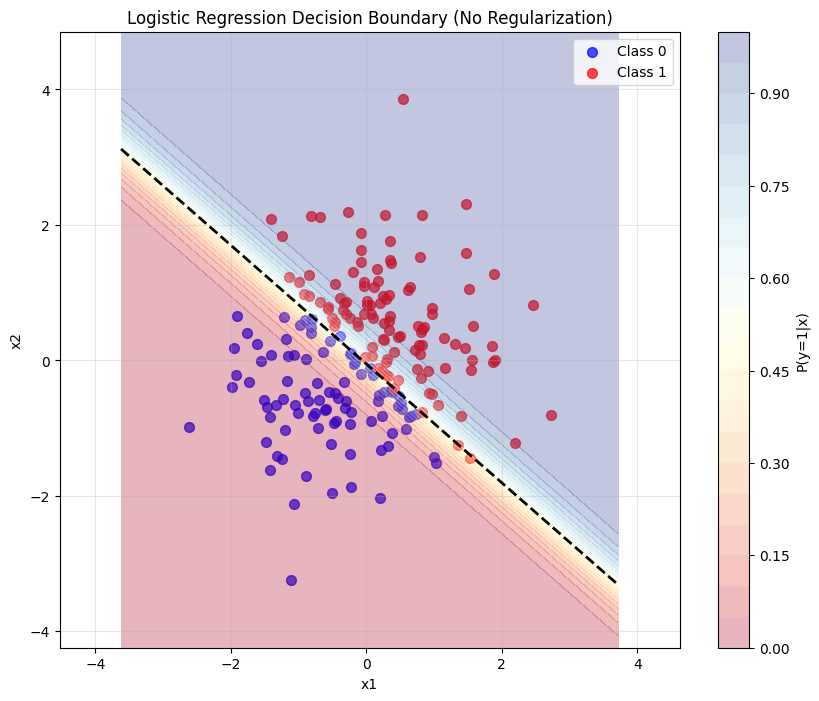

Training accuracy: 0.9850 (98.5%)

Example predictions:
Point 0: True=1, Pred=1, Prob=0.965
Point 1: True=1, Pred=1, Prob=0.873
Point 2: True=1, Pred=1, Prob=0.999
Point 3: True=1, Pred=1, Prob=1.000
Point 4: True=0, Pred=0, Prob=0.002


In [7]:
def plot_decision_boundary(w, b, X, y, title="Decision Boundary"):
    """
    Plot the decision boundary and data points.
    
    Args:
        w: Weight vector (2,)
        b: Bias term (scalar)
        X: Input features (m, 2)
        y: True labels (m,)
        title: Plot title
    """
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), 
                         np.linspace(y_min, y_max, 200))
    
    # Compute decision boundary: w[0]*x1 + w[1]*x2 + b = 0
    Z = w[0] * xx + w[1] * yy + b
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot decision boundary
    plt.contour(xx, yy, Z, levels=[0.0], colors='black', linewidths=2, linestyles='--')
    
    # Plot data points
    plt.scatter(X[y==0, 0], X[y==0, 1], s=50, label='Class 0', alpha=0.7, color='blue')
    plt.scatter(X[y==1, 0], X[y==1, 1], s=50, label='Class 1', alpha=0.7, color='red')
    
    # Add probability contours
    Z_prob = sigmoid(Z)
    contour = plt.contourf(xx, yy, Z_prob, levels=20, alpha=0.3, cmap='RdYlBu')
    plt.colorbar(contour, label='P(y=1|x)')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

# Plot the decision boundary
plot_decision_boundary(model['w'], model['b'], X, y, 
                      "Logistic Regression Decision Boundary (No Regularization)")

# Calculate accuracy
predictions = sigmoid(X @ model['w'] + model['b']) >= 0.5
accuracy = np.mean(predictions == y)
print(f"Training accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Show some example predictions
print("\nExample predictions:")
for i in range(5):
    prob = sigmoid(X[i] @ model['w'] + model['b'])
    pred = prob >= 0.5
    print(f"Point {i}: True={y[i]}, Pred={int(pred)}, Prob={prob:.3f}")

## 7. Regularization - Fighting Overfitting

### The Problem of Overfitting

Our current model might be **overfitting** - it's memorizing the training data too well and won't generalize to new data. This often happens when:
- The model is too complex for the amount of data
- The model has too many parameters
- The training data is noisy

### L2 Regularization (Ridge)

Regularization adds a penalty term to prevent the weights from becoming too large:

\[
J(w, b) = -\frac{1}{m} [y^T \log(f) + (1-y)^T \log(1-f)] + \frac{\lambda}{2m} ||w||^2
\]

**Key effects:**
- **λ = 0**: No regularization (our current model)
- **λ > 0**: Penalizes large weights, encourages simpler models
- **λ too large**: Underfitting (model becomes too simple)

Let's see how different λ values affect our model!

Training models with different regularization strengths...

λ = 0.0
--------------------
Final cost: 0.136240
Weights: w = [3.43401613 3.91671327]
Bias: b = 0.202194
Training accuracy: 0.9850 (98.5%)
Weight magnitude: ||w|| = 5.2089

λ = 0.1
--------------------
Final cost: 0.145225
Weights: w = [3.35074077 3.82834083]
Bias: b = 0.202554
Training accuracy: 0.9850 (98.5%)
Weight magnitude: ||w|| = 5.0876

λ = 1.0
--------------------
Final cost: 0.204875
Weights: w = [2.75073231 3.18728096]
Bias: b = 0.205690
Training accuracy: 0.9800 (98.0%)
Weight magnitude: ||w|| = 4.2101

λ = 10.0
--------------------
Final cost: 0.376316
Weights: w = [1.23331058 1.48478706]
Bias: b = 0.205281
Training accuracy: 0.9600 (96.0%)
Weight magnitude: ||w|| = 1.9302


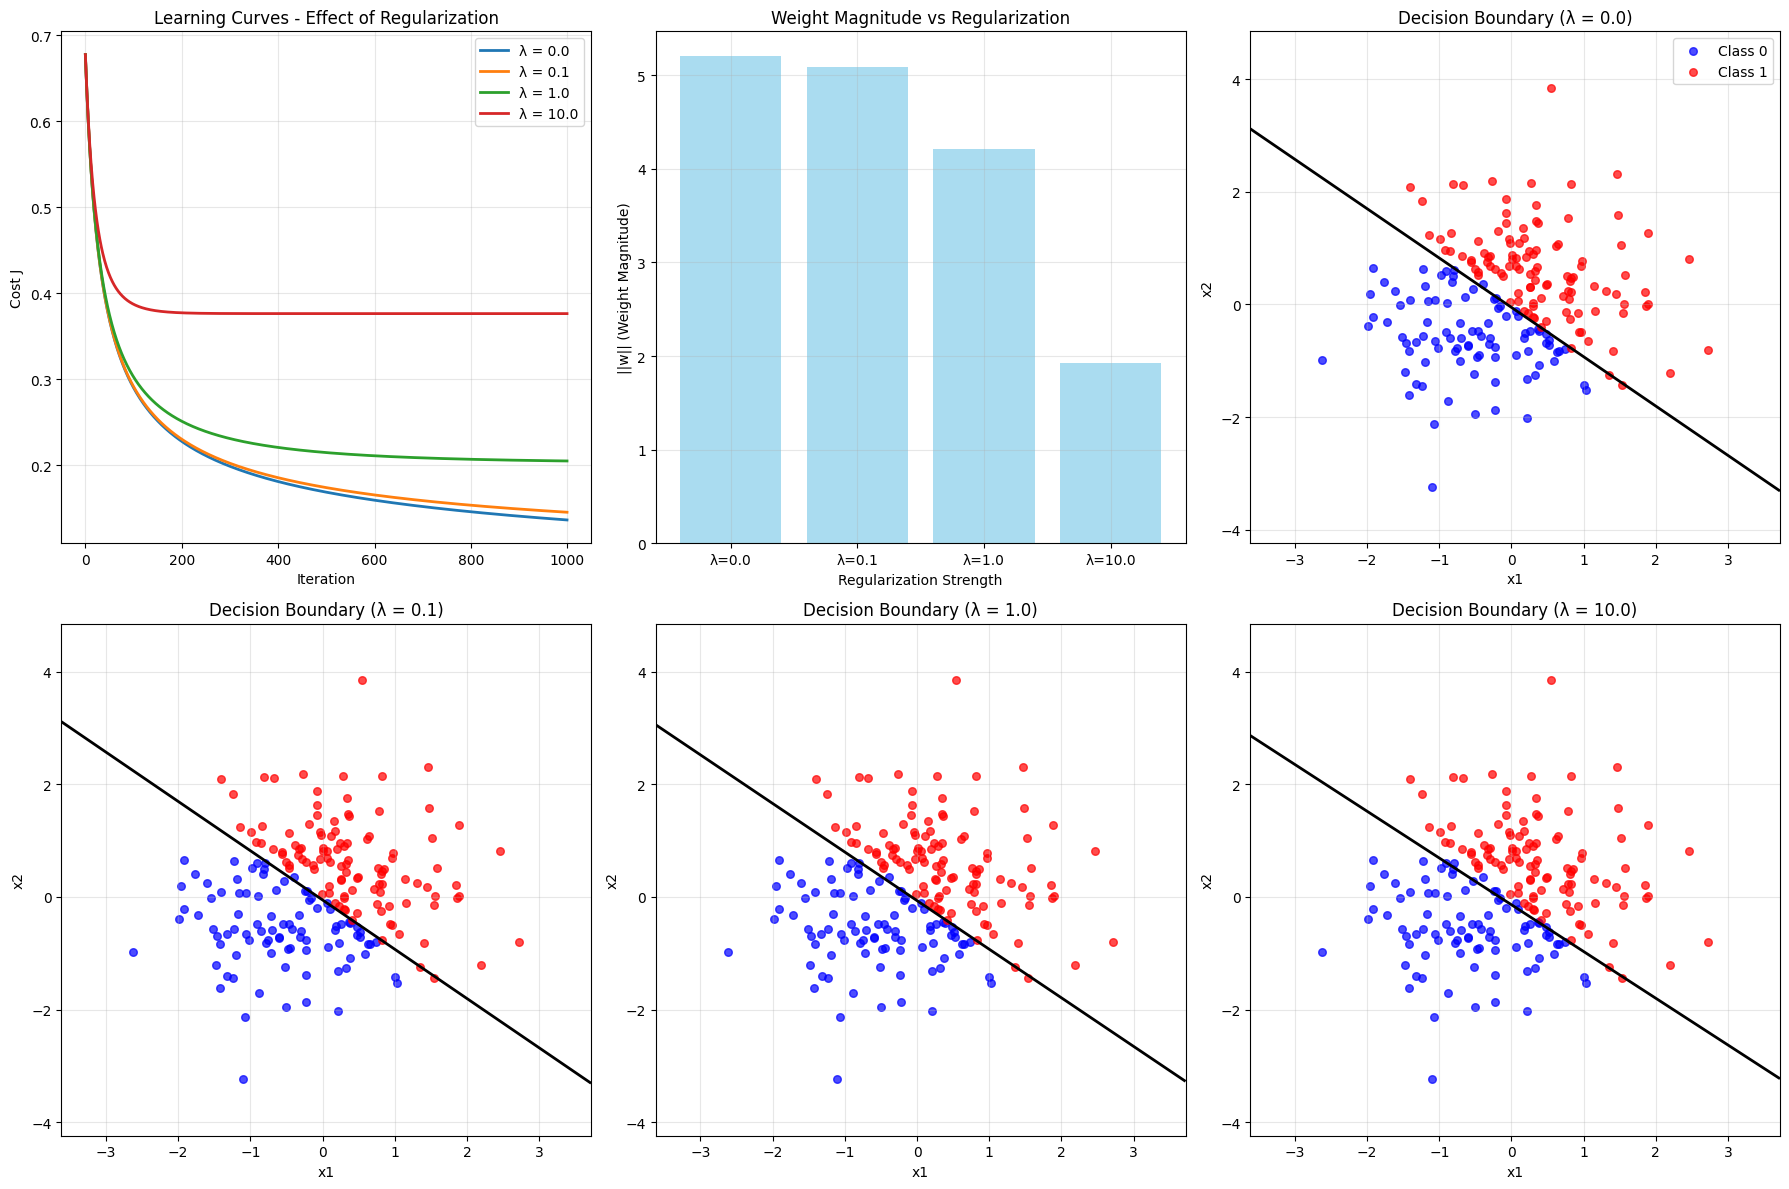


REGULARIZATION ANALYSIS SUMMARY
λ        Final Cost   ||w||      Accuracy   Effect
--------------------------------------------------------------------------------
0.0      0.1362       5.2089     0.9850     No regularization
0.1      0.1452       5.0876     0.9850     Light regularization
1.0      0.2049       4.2101     0.9800     Moderate regularization
10.0     0.3763       1.9302     0.9600     Heavy regularization

Key Insights:
• Higher λ → smaller weights → simpler decision boundary
• Very high λ → underfitting (too simple)
• Very low λ → overfitting (too complex)
• Optimal λ balances bias and variance


In [8]:
# Test different regularization strengths
lambdas = [0.0, 0.1, 1.0, 10.0]
results = {}

print("Training models with different regularization strengths...")
print("=" * 60)

for lam in lambdas:
    print(f"\nλ = {lam}")
    print("-" * 20)
    
    # Train model
    out = gradient_descent(X, y, alpha=0.1, iters=1000, reg_lambda=lam, verbose=False)
    results[lam] = out
    
    # Calculate accuracy
    predictions = sigmoid(X @ out['w'] + out['b']) >= 0.5
    accuracy = np.mean(predictions == y)
    
    print(f"Final cost: {out['J_hist'][-1]:.6f}")
    print(f"Weights: w = {out['w']}")
    print(f"Bias: b = {out['b']:.6f}")
    print(f"Training accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"Weight magnitude: ||w|| = {np.linalg.norm(out['w']):.4f}")

# Plot learning curves
plt.figure(figsize=(18, 12))  # Adjusted for 2x3 subplot layout

# Learning curves
plt.subplot(2, 3, 1)  # Learning curves
for lam in lambdas:
    plt.plot(results[lam]['J_hist'], label=f'λ = {lam}', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cost J')
plt.title('Learning Curves - Effect of Regularization')
plt.legend()
plt.grid(True, alpha=0.3)

# Weight magnitudes
plt.subplot(2, 3, 2)  # Weight magnitudes
weight_mags = [np.linalg.norm(results[lam]['w']) for lam in lambdas]
plt.bar(range(len(lambdas)), weight_mags, color='skyblue', alpha=0.7)
plt.xlabel('Regularization Strength')
plt.ylabel('||w|| (Weight Magnitude)')
plt.title('Weight Magnitude vs Regularization')
plt.xticks(range(len(lambdas)), [f'λ={lam}' for lam in lambdas])
plt.grid(True, alpha=0.3)

# Decision boundaries
for i, lam in enumerate(lambdas):
    plt.subplot(2, 3, i+3)  # Fixed: 2x3 grid to accommodate 4 regularization plots
    
    # Create a simple decision boundary plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                         np.linspace(y_min, y_max, 100))
    Z = results[lam]['w'][0] * xx + results[lam]['w'][1] * yy + results[lam]['b']
    
    plt.contour(xx, yy, Z, levels=[0.0], colors='black', linewidths=2)
    plt.scatter(X[y==0, 0], X[y==0, 1], s=30, label='Class 0', alpha=0.7, color='blue')
    plt.scatter(X[y==1, 0], X[y==1, 1], s=30, label='Class 1', alpha=0.7, color='red')
    plt.title(f'Decision Boundary (λ = {lam})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    if i == 0:  # Only show legend on first subplot
        plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 80)
print("REGULARIZATION ANALYSIS SUMMARY")
print("=" * 80)
print(f"{'λ':<8} {'Final Cost':<12} {'||w||':<10} {'Accuracy':<10} {'Effect'}")
print("-" * 80)
for lam in lambdas:
    cost = results[lam]['J_hist'][-1]
    w_mag = np.linalg.norm(results[lam]['w'])
    pred = sigmoid(X @ results[lam]['w'] + results[lam]['b']) >= 0.5
    acc = np.mean(pred == y)
    
    if lam == 0:
        effect = "No regularization"
    elif lam < 1:
        effect = "Light regularization"
    elif lam < 5:
        effect = "Moderate regularization"
    else:
        effect = "Heavy regularization"
    
    print(f"{lam:<8} {cost:<12.4f} {w_mag:<10.4f} {acc:<10.4f} {effect}")

print("\nKey Insights:")
print("• Higher λ → smaller weights → simpler decision boundary")
print("• Very high λ → underfitting (too simple)")
print("• Very low λ → overfitting (too complex)")
print("• Optimal λ balances bias and variance")

### Key Takeaways

- Use logistic loss (not squared error) for classification problems
- Decision boundary occurs where w·x + b = 0, creating linear separators
- L2 regularization prevents overfitting by penalizing large weights
- Feature scaling is crucial for efficient gradient descent convergence
- Monitor learning curves to tune hyperparameters and detect convergence
- Regularization strength (λ) controls the bias-variance tradeoff
- Logistic regression is essentially a single-neuron neural network

_End of notebook._
